In [74]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import seaborn as sns
import prophet as pt
import time
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
from vnstock import *

sns.set_style('whitegrid')
plt.style.use("default")
yf.pdr_override()
%matplotlib inline


In [75]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * 10)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)
display(df.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-10-11,17.392500,17.637142,17.327143,17.600357,15.360732,267738800
2013-10-14,17.493929,17.770714,17.476786,17.715714,15.461407,261898000
2013-10-15,17.768213,17.928572,17.697144,17.809999,15.543694,320073600
2013-10-16,17.885357,17.947500,17.829643,17.896786,15.619438,251101200
2013-10-17,17.856428,18.027857,17.845715,18.017857,15.725110,253593200


In [76]:
# df = pd.DataFrame(listing_companies())
# search_word = 'mobile'
# result = df[df['organName'].str.contains(search_word)]
# print(result)


In [77]:
# company_overview('VIC')


In [78]:
# df = stock_historical_data("VIC", "2020-01-01", "2023-09-30", "1D")
# df = pd.DataFrame(df)
# df


In [79]:
class DeepEvolutionStrategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def getWeights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
            lasttime = time.time()
            for i in range(epoch):
                population = []
                rewards = np.zeros(self.population_size)
                for k in range(self.population_size):
                    x = []
                    for w in self.weights:
                        x.append(np.random.randn(*w.shape))
                    population.append(x)
                for k in range(self.population_size):
                    weights_population = self._get_weight_from_population(
                        self.weights, population[k]
                    )
                    rewards[k] = self.reward_function(weights_population)
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
                for index, w in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    self.weights[index] = (
                        w
                        + self.learning_rate
                        / (self.population_size * self.sigma)
                        * np.dot(A.T, rewards).T
                    )
                if (i + 1) % print_every == 0:
                    print(
                        f'Training Epoch {i + 1}. Final Reward: {self.reward_function(self.weights)}'
                    )
            print('=====================================')
            print(f'Training Time: {time.time() - lasttime} seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def getWeights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.weights, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self.weights = pickle.load(file)


In [80]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.getWeights(),
            self.getReward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def getState(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def getReward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.getState(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.getState(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('Day %s > Buy 1 share at price %s, Total Asset %s' % (
                    str(t).rjust(3),
                    str("%.5f" % self.trend[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10)
                ))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('Day %s > Sell 1 share at price %s, Total Asset %s > Profit %s %%' % (
                    str(t).rjust(3),
                    str("%.5f" % close[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10),
                    str("%.2f" % invest).rjust(5)
                ))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [82]:
# close = df["close"].tolist()
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000


In [ ]:
# model.load_model('D:\Time-series-forecasting\model\deepES_model_AAPL.hdf5')


In [83]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 100)

model.save_model('D:\Time-series-forecasting\model\deepES_model_AAPL_10y')


Training Epoch 100. Final Reward: 416.2913348960877
Training Epoch 200. Final Reward: 391.37787534713743
Training Epoch 300. Final Reward: 461.047806930542
Training Epoch 400. Final Reward: 465.8083223724366
Training Epoch 500. Final Reward: 466.409870929718
Training Time: 4682.332191944122 seconds


In [84]:
states_buy, states_sell, total_gains, invest = agent.buy()


Day   0 > Buy 1 share at price   17.60036, Total Asset   9982.400
Day   1 > Buy 1 share at price   17.71571, Total Asset   9964.684
Day   2 > Buy 1 share at price   17.81000, Total Asset   9946.874
Day   3 > Buy 1 share at price   17.89679, Total Asset   9928.977
Day   4 > Buy 1 share at price   18.01786, Total Asset   9910.959
Day   5 > Buy 1 share at price   18.17464, Total Asset   9892.785
Day   6 > Buy 1 share at price   18.62000, Total Asset   9874.165
Day   7 > Buy 1 share at price   18.56679, Total Asset   9855.598
Day   8 > Buy 1 share at price   18.74857, Total Asset   9836.849
Day   9 > Buy 1 share at price   18.99679, Total Asset   9817.853
Day  10 > Buy 1 share at price   18.78429, Total Asset   9799.068
Day  11 > Buy 1 share at price   18.92429, Total Asset   9780.144
Day  12 > Buy 1 share at price   18.45286, Total Asset   9761.691
Day  13 > Buy 1 share at price   18.74643, Total Asset   9742.945
Day  14 > Buy 1 share at price   18.66786, Total Asset   9724.277
Day  15 > 

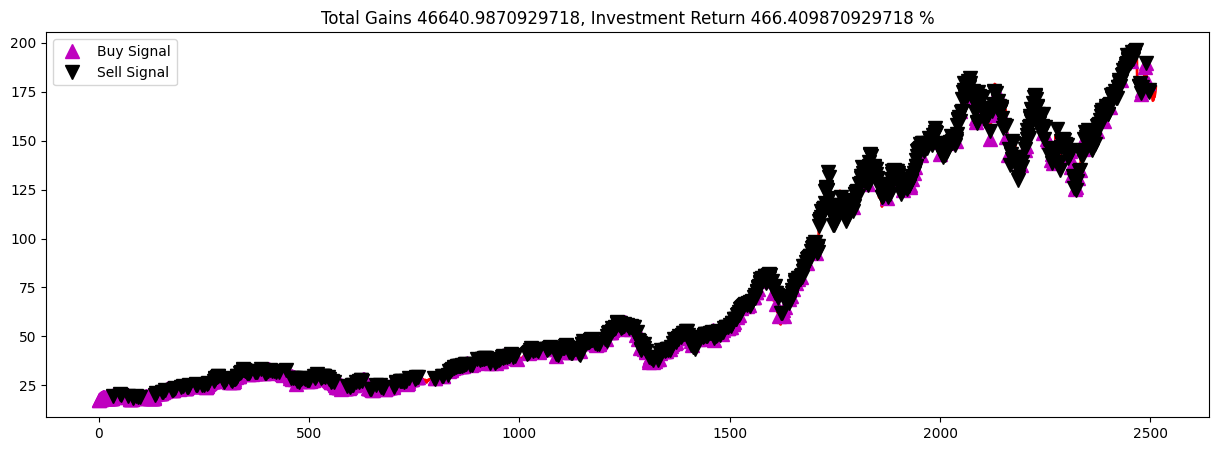

In [85]:
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='Buy Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Sell Signal', markevery=states_sell)
plt.title(f'Total Gains {total_gains}, Investment Return {invest} %')
plt.legend()
plt.show()
